Für ein besseres Verständnis des Observation Spaces anhand des Einheitskreises:

![EInheitskreis](./Sinus_und_Kosinus_am_Einheitskreis_Pendulum.png)  
Die Werte *x = cos(theta)* und *y = sin(theta)* entsprechen den beiden ersten Beobachten des Observation Space, dritte Beobachtung ist die Winkelgeschwindigkeit


In [1]:
import tensorflow as tf
import numpy as np
import random 
import gymnasium as gym
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import imageio
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import os

import collections
import math


In [2]:
# Setze den Environment Name
environment_name = 'Pendulum-v1'

#### 🌎 **Zufällige Action-Auswahl**

In [3]:
# Definiere die Anzahl der Episoden für die Bewertung
num_episodes = 100

# Funktion zur Bewertung des Modells
def evaluate(env, num_episodes=100):
    returns = []
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        terminated = False
        total_reward = 0
        while not done and not terminated:
            action = env.action_space.sample()
            state, reward, done, terminated, info = env.step(action)
            total_reward += reward
        returns.append(total_reward)
        #print(f"Episode {episode + 1}: Total Reward: {total_reward}")
    
    # Durchschnittliche Rückgabe berechnen
    average_return = sum(returns) / num_episodes
    print(f"Durchschnittlicher Reward über {num_episodes} Episoden: {average_return}")
    return returns

# Modell bewerten
env = gym.make(environment_name)
returns = evaluate(env, num_episodes=num_episodes)

Durchschnittlicher Reward über 100 Episoden: -1205.112167609979


In [4]:
env = gym.make(environment_name, render_mode="human")

num_episodes = 10

for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = env.action_space.sample()
            state, reward, done, terminated, info = env.step(action)
            done = done or terminated
            total_reward += reward
        returns.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward: {total_reward}")

Episode 1: Total Reward: -845.1605400609818
Episode 2: Total Reward: -1707.5209421305804
Episode 3: Total Reward: -1450.7851146192609
Episode 4: Total Reward: -1274.6494060541572
Episode 5: Total Reward: -748.4805952662898
Episode 6: Total Reward: -887.3057916838463
Episode 7: Total Reward: -1194.7734489892853
Episode 8: Total Reward: -1736.9463243726084
Episode 9: Total Reward: -762.2873477072197
Episode 10: Total Reward: -1164.0464430536315


## 💿 **Data Sampling**

In [42]:
# Define constants for column names
COS_ANGLE = "cosAngle"
SIN_ANGLE = "sinAngle"
ANG_VEL = "angVel"
EPISODE = "episode"
STEP = "step"
ACTION = "action"

def sample_data(episodes=10000, seed=0):
    # Create the Pendulum environment
    env = gym.make("Pendulum-v1")
    
    # Create an empty list to store transitions
    transitions = []

    # Sample data
    for episode in range(episodes):
        obs, info = env.reset()
        step = 0
        done = False

        while not done:
            step += 1
            action = env.action_space.sample()

            transitions.append({COS_ANGLE: obs[0], SIN_ANGLE: obs[1], 
                                ANG_VEL: obs[2], EPISODE: episode, 
                                STEP: step, ACTION: action[0]})

            obs, reward, done, terminated, _ = env.step(action)
            done = done or terminated

    # Convert the list of transitions to a Pandas DataFrame
    return pd.DataFrame(transitions)

# Sample data
df = sample_data(episodes=200, seed=0)
len(df)

40000

In [43]:
df.head()

,cosAngle,sinAngle,angVel,episode,step,action
0,-0.726437,0.687233,-0.550947,0,1,0.182465
1,-0.726157,0.687529,-0.008152,0,2,0.003864
2,-0.743386,0.668863,0.508075,0,3,-1.210133
3,-0.770439,0.637514,0.828202,0,4,-0.212884
4,-0.809470,0.587161,1.274405,0,5,0.741090


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

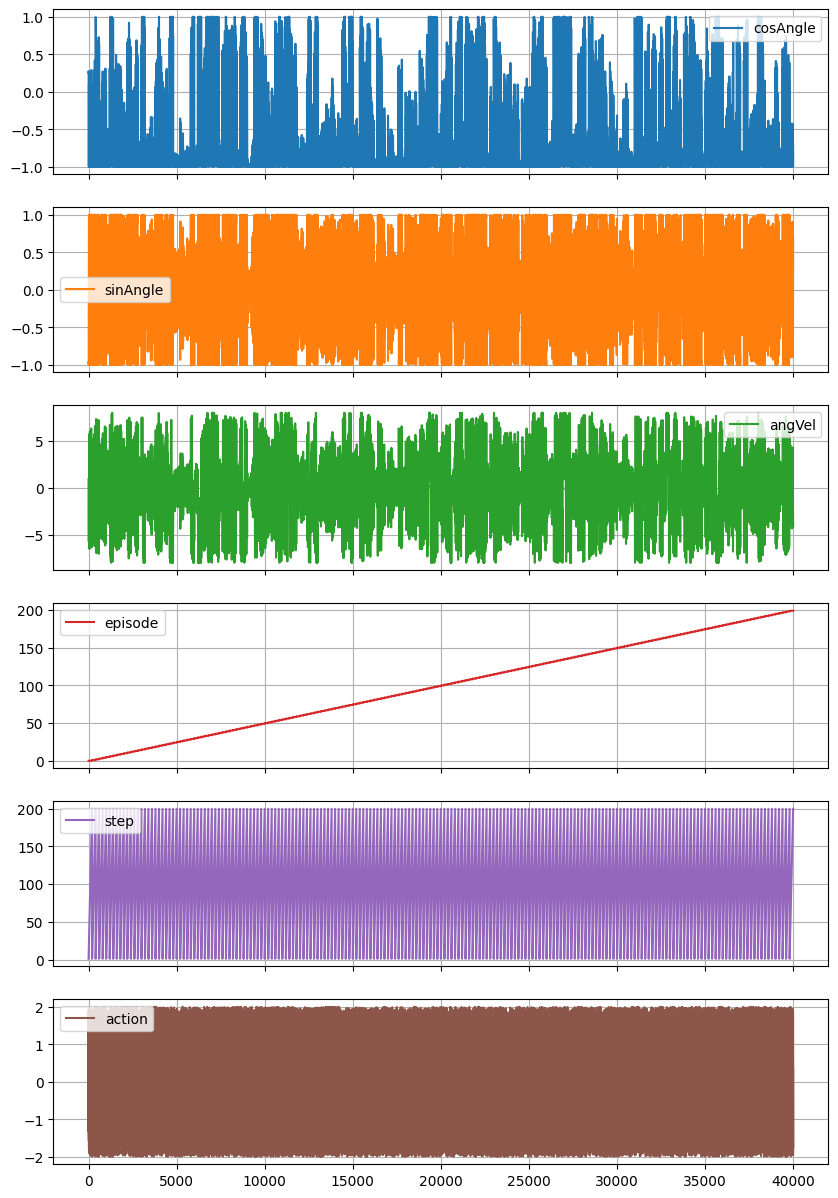

In [5]:
df.plot(subplots=True, figsize=(10,15), grid=True)

## ✂️ **Cut Out Data**

Die Werte in folgendem Bild dienen nur als Orientierung für das Winkel zu Bogenmaß Verhältnis, dies muss gemäß der Definition des Pendulum Environmens aber abgewandelt werden. Wir wollen dann den Winkelbereich [+60°, +120°] herausfiltern, um diesen Bereich für das Modell unbekannt zu machen.

Wir schneiden den folgenden Bereich aus den Daten:
( $\frac{1}{2}$ , $\frac{\sqrt{3}}{2}$ ) bis ($-\frac{1}{2}$ ,$\frac{\sqrt{3}}{2}$ ) (vgl. Abb. unten, wobei die Abbildung gedreht werden muss --> custom Abbildung folgt noch). 

![EInheitskreis](./Einheitskreis_Winkel.png)  

Beachte, das Bogenmaß ist hier anders definiert. Nach dem Pendulum Environment ist 0° definiert als das Pendel in der upright position.
Damit sind alle anderen Werte von *theta* im Intervall [$-\pi$, $\pi$]. Positive Werte deuten eine Position im rechten Bereich des Pendulumkreises an, negative wiederum deute auf eine aktuelle Position im linken Bereich des Pendulumkreises an.


In [44]:
# Berechne den Winkel (theta) basierend auf den x- und y-Werten
df['theta_winkel'] = np.arctan2(df[SIN_ANGLE], df[COS_ANGLE])

### Datenanalyse (optional)
    #print(df.head())
    #print(df[COS_ANGLE].max())
    #print(df[COS_ANGLE].min())
    #print(df[SIN_ANGLE].max())
    #print(df[SIN_ANGLE].min())
    #print(df['theta_winkel'].max())
    #print(df['theta_winkel'].min())
    #df['theta_rounded'] = np.round(df['theta_winkel'], decimals=3)
    #print(df[df['theta_rounded'] == 0])

### Definiere die Winkelgrenzen
lower_bound_theta_winkel = np.pi / 3        # +60°
upper_bound_theta_winkel = 2 * np.pi / 3   # +120°

### Filter für den Bereich auf dem Einheitskreis
cut_out_df = df[(df['theta_winkel'] <= lower_bound_theta_winkel) | (df['theta_winkel'] >= upper_bound_theta_winkel)]
print(len(cut_out_df))
print(cut_out_df.head())


34048
   cosAngle  sinAngle    angVel  episode  step    action  theta_winkel
0 -0.726437  0.687233 -0.550947        0     1  0.182465      2.383919
1 -0.726157  0.687529 -0.008152        0     2  0.003864      2.383511
2 -0.743386  0.668863  0.508075        0     3 -1.210133      2.408915
3 -0.770439  0.637514  0.828202        0     4 -0.212884      2.450325
4 -0.809470  0.587161  1.274405        0     5  0.741090      2.514045


In [45]:
### Check um richtiges cutten zu gewährleisten nur als Check
cut_out_df_check = df[(df['theta_winkel'] > lower_bound_theta_winkel) & (df['theta_winkel'] < upper_bound_theta_winkel)]
print(cut_out_df_check.head())
print(len(cut_out_df_check))

### Weiterführende Analyseoptionen
    #print(lower_bound_theta_winkel)
    #print(upper_bound_theta_winkel)
    #Kontrolle der x und y Koordinaten
    #print(cut_out_df_check[COS_ANGLE].min())
    #print(cut_out_df_check[COS_ANGLE].max())
    #print(cut_out_df_check[SIN_ANGLE].min())
    #zur Kontrolle müssen die Ergebnisse folgendes aufweisen: 
    #cosAngle im Intervall [-0.5, 0.5] und sinAngle > sqrt(3)/2 = 0.866

     cosAngle  sinAngle    angVel  episode  step    action  theta_winkel
214 -0.425654  0.904886 -4.462446        1    15  0.636486      2.010481
215 -0.252506  0.967595 -3.688309        1    16  1.724131      1.826065
216 -0.119781  0.992800 -2.703993        1    17  0.816495      1.690866
217 -0.028220  0.999602 -1.836918        1    18 -0.863925      1.599020
218  0.032611  0.999468 -1.216806        1    19 -1.978738      1.538180
5952


## 📊 **Data density**

### Kernel Density Estimation Model
Das Datendichtemodell wird als Kernel Density Estimation umgesetzt.  
Im Folgenden wird insbesondere auch der optimale bandwith-Parameter für die Kernel Density Estimation betrachtet.  
Außerdem werden verschieden Methoden zur Visualisierung eingesetzt.


In [46]:
#for kernel density
from sklearn.neighbors import KernelDensity
#for visualisation (3D plot, but not necessary)
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#for exploring the optimal bandwith parameter
from sklearn.model_selection import GridSearchCV

Mit folgendem Datendichtemodell *kde* kann für die generierten Daten die Datendichte berechnet werden. Diese Datendichtemodell kann daraufhin auf alle Daten bzw auch neu gesampelte Daten angewendet werden. Insbesondere ist keine neue Berechnung des Datendichtemodells notwendig.

C:\Users\Maximilian Schieder\AppData\Local\Temp\ipykernel_14448\3550292670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_out_df['kde_density'] = density


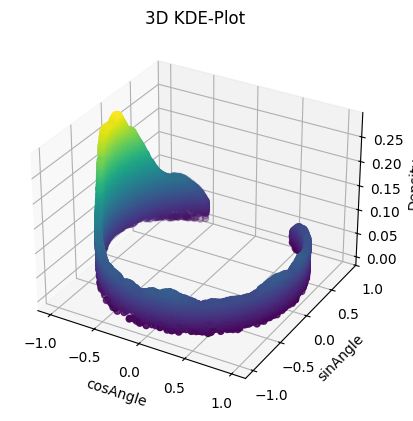

,cosAngle,sinAngle,angVel,episode,step,action,theta_winkel,kde_density
0,-0.726437,0.687233,-0.550947,0,1,0.182465,2.383919,0.092521
1,-0.726157,0.687529,-0.008152,0,2,0.003864,2.383511,0.098082
2,-0.743386,0.668863,0.508075,0,3,-1.210133,2.408915,0.096786
3,-0.770439,0.637514,0.828202,0,4,-0.212884,2.450325,0.087069
4,-0.809470,0.587161,1.274405,0,5,0.741090,2.514045,0.095294


In [54]:
## Kernel Density Modell (rausgecuttete Daten werden berücksichtigt)
# features: die betrachteten Parameter, für die eine Datendichte berechnet werden soll
features = cut_out_df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]
# Fit KDE model
kde = KernelDensity(kernel='gaussian', bandwidth = 0.1)  # optimal bandwidth will be determined below
kde.fit(features)

# calculate density score
log_density = kde.score_samples(features)
density = np.exp(log_density)
cut_out_df['kde_density'] = density

#plots for visualisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cut_out_df[COS_ANGLE]
y = cut_out_df[SIN_ANGLE]
z = cut_out_df['kde_density']

ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel(COS_ANGLE)
ax.set_ylabel(SIN_ANGLE)
ax.set_zlabel('Density')
plt.title('3D KDE-Plot')
plt.show()
cut_out_df.head()


### Finding the best Bandwith Parameter
#### Cross Validation
Testen auf verschieden Bandwith Parameter. Bewertung durch den GridSearchCV Algorithmus (cross validation, 5-fold, betrachtet nur den mean)  
Alternative Bewertung anhand des Qutienten von Mittelwert (wie gut fittet das Modell) und Standardabweichung (wie stabil ist das Modell)

In [57]:
features = cut_out_df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]
bandwidths = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]


# GridSearchCV zur Bandwidth-Optimierung
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold is default value
#macht es sinn,auf unterschiedliche verteilungen zu testen (also z.b. nicht Gaussian)

grid.fit(features)

best_bandwidth = grid.best_params_['bandwidth']
print(f'Optimale Bandwidth: {best_bandwidth}')

# anschauliche Ausgabe der Ergebnisse
cv_results = grid.cv_results_

mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']
bandwidths = cv_results['param_bandwidth']

# Berechne den Quotienten als Alternative zur Bewertung der optimalen Bandwith
quotients = mean_scores / std_scores

# Erstelle ein DataFrame zur übersichtlichen Darstellung
results_df = pd.DataFrame({
    'Bandwidth': bandwidths,
    'Mean Score': mean_scores,
    'Std Score': std_scores,
    'Mean / Std Quotient': quotients
})
print(results_df)

Optimale Bandwidth: 0.05
   Bandwidth    Mean Score    Std Score  Mean / Std Quotient
0       0.01 -23221.176632  4351.526873            -5.336328
1       0.05 -14107.385888   431.181989           -32.717939
2       0.10 -18620.893198   436.986098           -42.612095
3       0.20 -23376.315871   451.235970           -51.805081
4       0.30 -26232.933278   450.720008           -58.202283
5       0.50 -29911.396823   431.817215           -69.268653
6       0.70 -32284.386830   384.816453           -83.895547
7       1.00 -34855.351471   314.933641          -110.675225


### kdeplot (seaborn)
Anhand des Plots kann durch Visualisierung ein passender bandwith parameter gefunden werden. Insbesondere soll sowohl overfitting als auch underfitting vermieden werden.

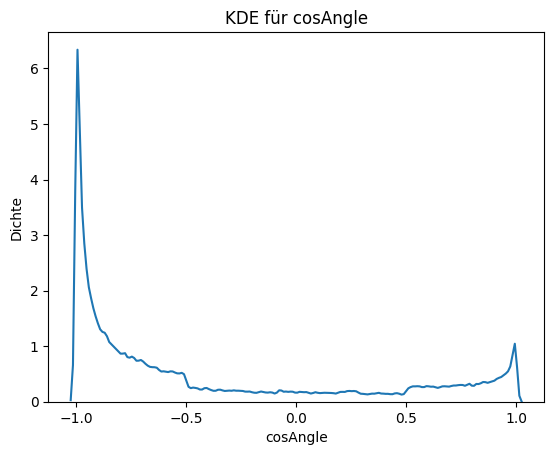

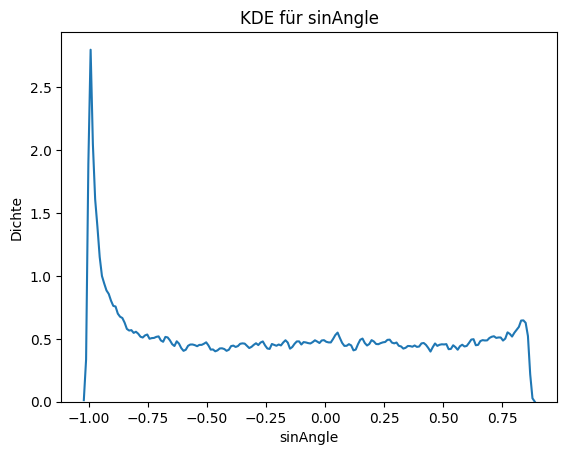

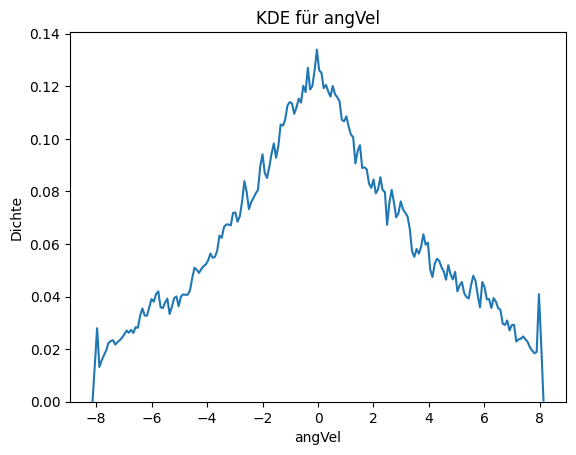

In [59]:
#plot Density for both parameters
sns.kdeplot(cut_out_df[COS_ANGLE], bw_adjust=0.1)
plt.title('KDE für cosAngle')
plt.xlabel('cosAngle')
plt.ylabel('Dichte')
plt.show()

sns.kdeplot(cut_out_df[SIN_ANGLE], bw_adjust=0.1)
plt.title('KDE für sinAngle')
plt.xlabel('sinAngle')
plt.ylabel('Dichte')
plt.show()

sns.kdeplot(cut_out_df[ANG_VEL], bw_adjust=0.1)
plt.title('KDE für angVel')
plt.xlabel('angVel')
plt.ylabel('Dichte')
plt.show()

### Applying the data density model (kde) to any newly generated data.

In [55]:
features = df[[COS_ANGLE, SIN_ANGLE, ANG_VEL]]

# Berechne die Dichte für die gesampelten Daten
log_density = kde.score_samples(features)
density_sampled_data = np.exp(log_density)
df['kde_density'] = density_sampled_data

#print(df)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df[COS_ANGLE]
y = df[SIN_ANGLE]
z = df['kde_density']

ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel(COS_ANGLE)
ax.set_ylabel(SIN_ANGLE)
ax.set_zlabel('Density')
plt.title('3D KDE-Plot')
plt.show()
cut_out_df.head()

       cosAngle  sinAngle    angVel  episode  step    action  theta_winkel  \
0     -0.726437  0.687233 -0.550947        0     1  0.182465      2.383919   
1     -0.726157  0.687529 -0.008152        0     2  0.003864      2.383511   
2     -0.743386  0.668863  0.508075        0     3 -1.210133      2.408915   
3     -0.770439  0.637514  0.828202        0     4 -0.212884      2.450325   
4     -0.809470  0.587161  1.274405        0     5  0.741090      2.514045   
...         ...       ...       ...      ...   ...       ...           ...   
39995 -0.994573 -0.104039 -2.895188      199   196 -0.260163     -3.037365   
39996 -0.998924  0.046368 -3.012242      199   197  1.278260      3.095208   
39997 -0.982813  0.184606 -2.785727      199   198  1.773406      2.955922   
39998 -0.953927  0.300039 -2.381262      199   199  0.071560      2.836859   
39999 -0.916318  0.400451 -2.145499      199   200 -1.886027      2.729584   

       kde_density  
0         0.092521  
1         0.098082  


## 🗺️ **Model Based RFL**

In [10]:
#############################################
#### HELPER FUNCTIONS FOR PATTERN GENERATION
#############################################
def create_training_data(data, input_col, target_col, window_size=1, training_pattern_percent=0.7):

    data_train = data

    mean_in, std_in = mean_and_std(input_col, data_train)
    mean_out, std_out = mean_and_std(target_col, data_train)
    #data_plot.plot_hist_df(data_train, input_col)
    #data_plot.plot_timeseries_df(data_train, input_col)
    print(f"mean in = {mean_in}" )
    print(f"std in = {std_in}")
    print(f"mean out =  {mean_out}")
    print(f"std out = {std_out}")

    grouped = data_train.groupby(['episode'])

    inputs_all = []
    labels_all = []

    for g in grouped:
        # be sure that data inside a group is not shuffled # not sure if needed
        g = g[1].sort_values(by='step')

        past_history = window_size   # t-3, t-2, t-1, t
        future_target = 0  # t+1
        STEP = 1 # no subsampling of rows in data, e.g. only every i'th row

        # use pandas.DataFrame.values in order to get an numpy array from an pandas.DataFrame object

        inputs, labels = multivariate_data(dataset=g[input_col][:].values, target=g[target_col][:].values,
                                        start_index=0, end_index=g[input_col][:].values.shape[0]-future_target,
                                        history_size=past_history, target_size=future_target, step=STEP,
                                        single_step=True)

        ## Append data to whole set of patterns
        for i in range (0, len(inputs)):
            inputs_all.append(inputs[i])
            labels_all.append(labels[i])
  
    length = len(inputs_all)

    c = list(zip(inputs_all, labels_all))
    np.random.shuffle(c)
    inputs_all, labels_all = zip(*c)

    split = int(training_pattern_percent * length)

    inputs_all = np.array(inputs_all)
    labels_all = np.array(labels_all)

    return ((inputs_all[0:split], labels_all[0:split]), (inputs_all[split:], labels_all[split:])), mean_in, std_in, mean_out, std_out


def mean_and_std(columns, data):
    mean = np.zeros(len(columns))
    std = np.zeros(len(columns))
    index = 0
    for c in columns:
        mean[index], std[index] = get_normalizations(data[c])
        index = index + 1
    return mean, std

def get_normalizations(data):
    mean = data.mean()
    std = data.std()
    return mean, std

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
       end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)



def prepare_data(df, input_col, target_col, window_size, training_batch_size=50, validation_batch_size=50, training_pattern_percent=0.7):
    
    global x_train_multi, y_train_multi
    
    ###################
    ## PREPARE DATASET
    ###################
    ((x_train_multi, y_train_multi), (x_val_multi, y_val_multi)), mean_in, std_in, mean_out, std_out = \
                                    create_training_data(df, input_col, target_col, window_size=window_size,
                                                        training_pattern_percent=training_pattern_percent)

    print('trainData: Single window of past history : {}'.format(x_train_multi[0].shape))
    print('trainData: Single window of future : {}'.format(y_train_multi[1].shape))
    print('valData: Single window of past history : {}'.format(x_val_multi[0].shape))
    print('valData: Single window of future : {}'.format(y_val_multi[1].shape))
    print('trainData: number of trainingsexamples: {}'.format(x_train_multi.shape))
    print('valData: number of trainingsexamples: {}'.format(x_val_multi.shape))

    train_data = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    #train_data = train_data.cache().shuffle(max_training_pattern).batch(training_batch_size).repeat()
    train_data = train_data.shuffle(x_train_multi.shape[0]).batch(training_batch_size).repeat()

    val_data = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data = val_data.batch(validation_batch_size).repeat()
    input_shape = x_train_multi[0].shape[-2:]
    return train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out


In [11]:
window_size=4
input_col = [COS_ANGLE, SIN_ANGLE, ANG_VEL, ACTION]
target_col = [COS_ANGLE, SIN_ANGLE, ANG_VEL]

train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out =  \
            prepare_data(df, input_col, target_col, window_size=window_size, training_pattern_percent=0.7)

print ("Input-Shape: ", input_shape)

mean in = [-0.36419022 -0.00096526 -0.01322524  0.00197949]
std in = [0.64587098 0.6709969  3.53603506 1.15856254]
mean out =  [-0.36419022 -0.00096526 -0.01322524]
std out = [0.64587098 0.6709969  3.53603506]
trainData: Single window of past history : (4, 4)
trainData: Single window of future : (3,)
valData: Single window of past history : (4, 4)
valData: Single window of future : (3,)
trainData: number of trainingsexamples: (27440, 4, 4)
valData: number of trainingsexamples: (11760, 4, 4)
Input-Shape:  (4, 4)


In [12]:
class NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self, mean, std, **kwargs):
        super(NormalizeLayer, self).__init__(**kwargs)
        self.mean = tf.constant(mean, dtype=tf.float32)
        self.std = tf.constant(std, dtype=tf.float32)

    def call(self, inputs):
        return (inputs - self.mean) / self.std

    def get_config(self):
        config = super(NormalizeLayer, self).get_config()
        config.update({
            'mean': self.mean.numpy().tolist(),
            'std': self.std.numpy().tolist(),
        })
        return config
    
# Registrieren Sie Ihre benutzerdefinierte Schicht
tf.keras.utils.get_custom_objects()['NormalizeLayer'] = NormalizeLayer

def build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape, optimizer=tf.keras.optimizers.RMSprop()):

    print(f"mean in = {mean_in}, std in = {std_in}, mean out = {mean_out}, std out = {std_out}")

    single_step_model = tf.keras.models.Sequential()
    
    # Use the custom Standardization layer
    single_step_model.add(NormalizeLayer(mean=mean_in, std=std_in, input_shape=input_shape))
    single_step_model.add(tf.keras.layers.LSTM(50, input_shape=input_shape, dtype=np.float32))
    single_step_model.add(tf.keras.layers.Dense(len(mean_out), activation="linear"))

    single_step_model.compile(optimizer=optimizer, loss="mse")

    return single_step_model

In [13]:
modelpath = "model.keras"
max_epochs = 1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

# Callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=True)
mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath="%s_bestTrainLoss.keras" % modelpath, monitor='loss', verbose=1, save_best_only=True, mode='min')
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath="%s_bestValLoss.keras" % modelpath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./model_logs_tb", histogram_freq=1)

# Modell erstellen
step_model = build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape)

# Modell trainieren
history = step_model.fit(train_data, epochs=max_epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_data, validation_steps=validation_steps, validation_freq=validation_freq,
                        callbacks=[mc_trainLoss_callback, mc_valLoss_callback, es_callback, tensorboard_callback])

# Modell speichern
step_model.save(modelpath)

mean in = [-0.36419022 -0.00096526 -0.01322524  0.00197949], std in = [0.64587098 0.6709969  3.53603506 1.15856254], mean out = [-0.36419022 -0.00096526 -0.01322524], std out = [0.64587098 0.6709969  3.53603506]


C:\Users\Maximilian Schieder\AppData\Local\Temp\ipykernel_7252\2376209938.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(NormalizeLayer, self).__init__(**kwargs)


c:\RFL\LMU_RFL_SoSe24\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8898
Epoch 1: loss improved from inf to 1.72375, saving model to model.keras_bestTrainLoss.keras

Epoch 1: val_loss improved from inf to 0.25202, saving model to model.keras_bestValLoss.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 2.8667 - val_loss: 0.2520
Epoch 2/1000
 96/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1611
Epoch 2: loss improved from 1.72375 to 0.09126, saving model to model.keras_bestTrainLoss.keras

Epoch 2: val_loss improved from 0.25202 to 0.01550, saving model to model.keras_bestValLoss.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1577 - val_loss: 0.0155
Epoch 3/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114
Epoch 3: loss improved from 0.09126 to 0.00848, saving model to model.keras_bestTrainLoss.keras

Epoch 3: val_loss improved from 0.01550 to 0.00583, saving model to model.keras_bestValLoss.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0114 - val_l

In [14]:
dfEval = sample_data(episodes=1)
#dfEval.describe()
dfEval = dfEval[dfEval.episode==0]

#row_max_steps = dfEval[dfEval.step == dfEval.step.max()]
#dfEval = dfEval[dfEval.episode==int(row_max_steps.episode)]

In [15]:
print(dfEval)

     cosAngle  sinAngle    angVel  episode  step    action
0    0.757455 -0.652887  0.354904        0     1 -1.307369
1    0.746551 -0.665328 -0.330866        0     2 -0.173526
2    0.717404 -0.696657 -0.855891        0     3  0.427145
3    0.670107 -0.742264 -1.314313        0     4  1.150763
4    0.604735 -0.796427 -1.698396        0     5  0.305980
..        ...       ...       ...      ...   ...       ...
195 -0.765140 -0.643865  7.013131        0   196  1.805442
196 -0.506573 -0.862197  6.801049        0   197  0.868905
197 -0.215270 -0.976555  6.284737        0   198 -0.690424
198  0.055441 -0.998462  5.448758        0   199  0.920891
199  0.293008 -0.956110  4.838045        0   200  1.715183

[200 rows x 6 columns]


In [16]:
output_min = y_train_multi.min(axis=0)
output_max = y_train_multi.max(axis=0)
print ("min(output)_data: ", output_min)
print ("max(output)_data: ", output_max)

min(output)_data:  [-1. -1. -8.]
max(output)_data:  [0.99999994 0.99999994 8.        ]


In [17]:
import collections

# load model
#model = tf.keras.models.load_model(modelpath, compile=False)
model = tf.keras.models.load_model("model.keras_bestValLoss.keras", compile=False)
#model = tf.keras.models.load_model("model.h5.bestTrainLoss", compile=False)
#############################################################################
# in case of error: AttributeError: 'str' object has no attribute 'decode'
# => Downgrade h5py package to version 2.10.0: pip install h5py==2.10.0
#############################################################################

# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[COS_ANGLE].values[i], dfEval[SIN_ANGLE].values[i],
                               dfEval[ANG_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        netOutput = model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            COS_ANGLE:netOutput[0], SIN_ANGLE:netOutput[1],
            ANG_VEL:netOutput[2]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], 
                                       dfEval[ACTION].values[i]]))
        
dfNet = pd.DataFrame(transitions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
[[[ 0.7465513  -0.66532785 -0.33086646 -0.17352608]
  [ 0.71740407 -0.6966573  -0.8558912   0.4271447 ]
  [ 0.67010725 -0.74226433 -1.3143126   1.150763  ]
  [ 0.60349387 -0.7907839  -1.6929001   0.30598   ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Bound-hit at step:  18  => terminating further evaluation


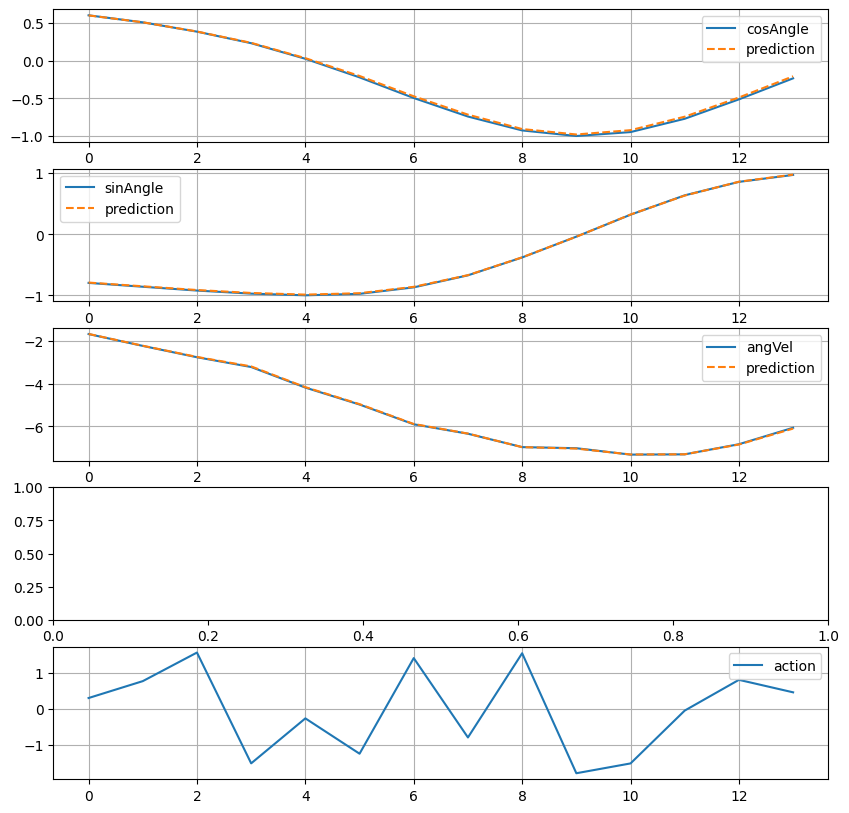

In [18]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [COS_ANGLE, SIN_ANGLE, ANG_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(dfNet)), dfEval[f].values[window_size:window_size+len(dfNet)], label=f)
    axs[i].plot(range (len(dfNet)), dfNet[f].values, label="prediction", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(dfNet)), dfEval[ACTION].values[window_size:window_size+len(dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")


# Learning Policies in the Pendulum Environment  
Be aware that the variable **env** as well as the variable **log_dir** is used twice in two different approaches. Mix ups might lead to misleading results.

## Function for tracking the best Policy
This function helps to save the best current policy.

In [90]:
from stable_baselines3.common.callbacks import BaseCallback
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param avg_episodes: (int) average over the past n episodes (default: 100)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    :param vec_norm_env: (VecNormalize) stable-baselines VecNormalize object (contains Gym env)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1, avg_episodes=100, vec_norm_env=None):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.best_timestep = -np.inf
        self.vec_norm_env = vec_norm_env
        self.avg_episodes = avg_episodes

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            
            if len(x) > 0:
                # Mean training reward over the last avg_episodes episodes
                mean_reward = np.mean(y[-self.avg_episodes:])

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.best_timestep = self.num_timesteps
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                    self.model.save(self.save_path)
                    if self.vec_norm_env is not None: 
                        self.vec_norm_env.save ("%s.env_normalizations" % self.save_path)

                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} (ts={}) - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, self.best_timestep, mean_reward))


        return True

## Online Learning using PPO (not model-based)  
This can serve as a baseline for comparing the performance of the model-based approach. Here we learn a policy while interacting with the environment.

In [88]:
log_dir = "logs_onlineLearning_PPO"
os.makedirs(log_dir, exist_ok=True)

In [24]:
#env = gym.make("CartPoleSwingUp-v0")
env = gym.make("Pendulum-v1")
env = Monitor(env, log_dir) # required for using callback functions during training

# optionally state normalization
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs=True, norm_reward=True) # State normalization

### Learning Policy

In [26]:
time_steps=100001

tensorboard_dir = "pendulum_onlineLearning_PPO"
os.makedirs(tensorboard_dir, exist_ok=True)

model_PPO_online = PPO('MlpPolicy', env, verbose=1, tensorboard_log=tensorboard_dir)

callback=SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir, avg_episodes=30, vec_norm_env=env)
model_PPO_online.learn(total_timesteps=time_steps, callback=callback)

Using cpu device
Logging to pendulum_onlineLearning_PPO\PPO_1
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.37e+03 |
| time/              |           |
|    fps             | 599       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -1.3e+03     |
| time/                   |              |
|    fps                  | 397          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0044147093 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -

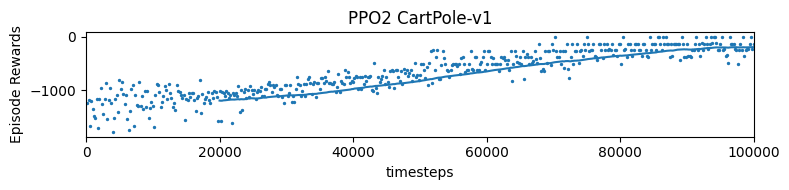

In [27]:
results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "PPO2 CartPole-v1")
plt.savefig("results.png")
plt.show()

### Evaulate Performance of learned Policy

In [89]:
model_PPO_online = PPO.load("%s/best_model.zip" % log_dir)


env = DummyVecEnv([lambda: gym.make("Pendulum-v1")])
# Load the saved statistics
env = VecNormalize.load("%s/best_model.env_normalizations" % log_dir, env)

for i in range (5): 
    state = env.reset()
    done=False
    cumReward = 0
    steps=0

    while not done: 
        steps += 1
        action, _states = model_PPO_online.predict(state)
        state, reward, done, _ = env.step(action)
        if done: 
            print (f"Episode {i} terminated after {steps} steps")
        cumReward += reward
        env.render() ## <- comment out in Google colab

    print ("steps=%d, cumReward=%.3f" % (steps, cumReward))

env.close()

[[-1.2921671   1.1250331  -0.21589322]]
Episode 0 terminated after 200 steps
steps=200, cumReward=-1.686
[[-0.30914974 -1.7909337  -0.17632996]]


C:\Users\Maximilian Schieder\AppData\Local\Temp\ipykernel_7252\852770313.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ("steps=%d, cumReward=%.3f" % (steps, cumReward))


Episode 1 terminated after 200 steps
steps=200, cumReward=-1.705
[[ 0.42811766 -1.4459935   0.02263335]]
Episode 2 terminated after 200 steps
steps=200, cumReward=-0.900
[[-1.3179616  -1.32129    -0.05611013]]
Episode 3 terminated after 200 steps
steps=200, cumReward=-1.643
[[-1.2274941  -1.4251771  -0.04009958]]
Episode 4 terminated after 200 steps
steps=200, cumReward=-1.656


## model-based RL with PPO
We are now taking our trained model of the environment to learn a optimal Policy

In [65]:
log_dir = "logs_modelBased_PPO"
os.makedirs(log_dir, exist_ok=True)

### Modify Gym Environment
Using our learned model (Zustandsübergangsmodell) in a custom environment. This enables us to train a policy without interacting with the "real world".

In [77]:
class PendulumModelBasedEnv (gym.Env):
    
    steps = 0
    model = None
    
    def __init__(self, model_filename="model.keras", window_size=4):
        self.model = tf.keras.models.load_model(model_filename, compile=False)
        self.window_size = window_size

        # FIFO-buffer to store state history
        self.stateBuffer = collections.deque(maxlen=window_size)
        
        # Pendulum constants (taken from Pendulum-v1)
        self.max_speed = 8
        self.max_torque = 2.0
        #self.dt = 0.05

        # Observation space: [cos(theta), sin(theta), theta_dot]
        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-high, high=high, dtype=np.float32)


    def step (self, action):
        self.steps +=1
        
        # Clip action to be within bounds, is that needed?
        action = np.clip(action, -self.max_torque, self.max_torque)[0]

        # append last state + new action to state buffer
        netInput = [self.currentState[0], self.currentState[1], self.currentState[2], action]
        self.stateBuffer.append(np.float64(netInput))
        state = np.array([list(self.stateBuffer)])
        
        # NN recall
        netOutput = self.model.predict(np.float64(state))[0]
                
        # retrieve new state
        self.currentState = np.float64([netOutput[0], netOutput[1], netOutput[2]])

        # Compute done condition
        done = False
        if self.steps >= 200:  # Episode ends after 200 steps
            done = True
            
        # Compute reward based on angle and speed
        theta = np.arctan2(self.currentState[1], self.currentState[0])  # angle from sin, cos
        theta_dot = self.currentState[2]
        #theta ist der Winkel (Abweichung von Null wird bestraft)
        #theta_dot ist die Winkelgeschwindigkeit (auch hier wird eine höhere winkelgeschwindigkeit bestraft)
        #action, also drehmoment, wird auch mit höheren kosten negativ bewertet
        reward = -(theta**2 + 0.1*theta_dot**2 + 0.001*(action**2))  # Standard Pendulum reward function

        ######################################################
        ############wichtig für density im reward #############
        #reward anpassen: um dichtewert zu bekommen, mit kde.score_samples auf die features des current state anwenden
        # dadurch dichte berechnen über log likelihood, diese dann in den reward mit einem faktor reinrechnen
        #########################################################

        return self.currentState, reward, done, {}, {}
    
    def render (self):
        pass
    
    def reset(self, seed = None): 
        self.steps = 0
        
        # if seed not none
        if seed is not None:
            np.random.seed(seed)

        # Random initial state (cos(theta), sin(theta), theta_dot)
        theta = np.random.uniform(low=-np.pi, high=np.pi)
        theta_dot = np.random.uniform(low=-1, high=1)
        
        # Convert to (cos(theta), sin(theta), theta_dot) for observation
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        initState = np.float64([cos_theta, sin_theta, theta_dot])

        # Fill the buffer with the same initial state
        for i in range(self.window_size):
            action_sample = self.action_space.sample()
            self.stateBuffer.append(np.append(initState, action_sample))

        self.currentState = initState
        #umwandeln für richtige ausgabe
        return np.expand_dims(self.currentState, axis=0), {}
        

### Learn Policy

In [78]:
#env = gym.make("CartPoleSwingUp-v0")
env = PendulumModelBasedEnv(model_filename="model.keras", window_size=4)
###########################
# Possible errors: 
# 
# 1) If the following error occurs: AttributeError: 'str' object has no attribute 'decode'
#    => Solution is downgrading h5py through: pip install h5py==2.10.0 --force-reinstall
#
# 2) If the following error occurs: NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array.
#    => Solution is downgrading numpy through: pip install numpy == 1.19.5

env = Monitor(env, log_dir) # required for using callback functions during training

# optionally state normalization
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs=True, norm_reward=True) # State normalization

In [80]:
time_steps=101000

tensorboard_dir = "pendulum_modelBased_PPO"
os.makedirs(tensorboard_dir, exist_ok=True)

model_modelBased_PPO = PPO('MlpPolicy', env, verbose=1, tensorboard_log=tensorboard_dir)

callback=SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir, avg_episodes=30, vec_norm_env=env)
model_modelBased_PPO.learn(total_timesteps=time_steps, callback=callback)

Using cpu device
Logging to pendulum_modelBased_PPO\PPO_3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━

KeyboardInterrupt: 

### Evaluate Results

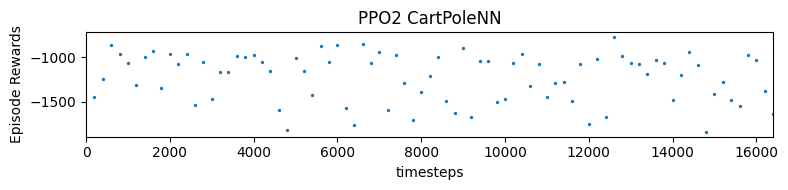

In [81]:
results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "PPO2 Pendulum")
plt.savefig("results-pendulum_modelBasedRL.png")
plt.show()

In [87]:
model_modelBased_PPO = PPO.load("%s/best_model.zip" % log_dir)

env = DummyVecEnv([lambda: gym.make("Pendulum-v1")])
# Load the saved statistics
env = VecNormalize.load("%s/best_model.env_normalizations" % log_dir, env)
env.training=False



for i in range (5): 
    state = env.reset()
    done=False
    cumReward = 0
    steps=0

    while not done: 
        steps += 1
        action, _states = model_modelBased_PPO.predict(state)
        state, reward, done, _ = env.step(action)
        if done: 
            print (f"Episode {i} terminated after {steps} steps")
        cumReward += reward
        env.render() ## <- comment out in Google colab

    print ("steps=%d, cumReward=%.3f" % (steps, cumReward))

env.close()

Episode 0 terminated after 200 steps
steps=200, cumReward=-4.768


C:\Users\Maximilian Schieder\AppData\Local\Temp\ipykernel_7252\2004844191.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ("steps=%d, cumReward=%.3f" % (steps, cumReward))


Episode 1 terminated after 200 steps
steps=200, cumReward=-5.818
Episode 2 terminated after 200 steps
steps=200, cumReward=-5.231
Episode 3 terminated after 200 steps
steps=200, cumReward=-4.760
Episode 4 terminated after 200 steps
steps=200, cumReward=-4.772
